In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import interp1d
from scipy.optimize import root

In [2]:
common_settings = {
'omega_b':0.0223828,
'h':0.67810,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':0,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',

# 'omega_cdm':0.4363,
'omega_cdm':0.11,

}

In [3]:
chiCDM = Class()
# pass input parameters
Mnu=0.1
chiCDM.set(common_settings)
aNR=1/1890/Mnu+2.42e-3
# kJ0p5 = 0.2
# aNR=0.0321*0.01/kJ0p5
# aNR=7.856e-03
print(f'aNR={aNR},zNR={1/aNR -1}')
chiCDM.set({
'N_ur': 3.046,
'omega_chi':0.00107363 ,
# 'omega_cdm':0.90,
# 'f_chi':0.1,
'acs_chi':aNR,
'cs2_peak_chi':1./3.
})

WCDM = Class()
WCDM.set(common_settings)
WCDM.set({
    'background_verbose':3,
    'N_ur': 2.0328,
    'N_ncdm':1,
    'omega_ncdm':0.02,
    'omega_cdm':0.1,
})


chiCDM.compute()
WCDM.compute()

aNR=0.007711005291005291,zNR=128.6847767912281
Computing sources
Running CLASS version v3.2.5
Computing background
 -> non-cold dark matter species with i=1 has m_i = 1.862866e+00 eV (so m_i / omega_i =9.314331e+01 eV)
 -> ncdm species i=1 sampled with 11 (resp. 11) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 1.0132
Chose ndf15 as generic_evolver
 -> age = 13.774252 Gyr
 -> conformal age = 14168.705133 Mpc
 -> N_eff = 3.046 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3403.375394
    corresponding to conformal time = 114.386094 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.217477        , omega = 0.1            
 ---> Non-Cold Dark Matter Species (incl. massive neutrinos)

0.04036534972084581 0.766633207404969


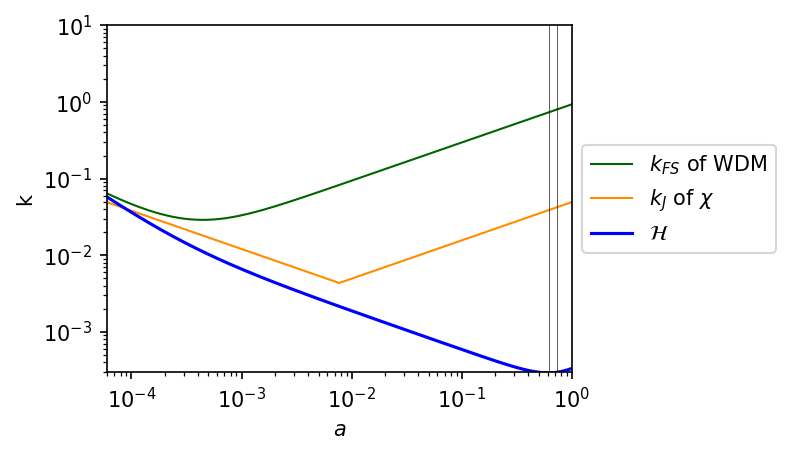

In [4]:
plt.figure(figsize=(4,3), dpi=150)

background = chiCDM.get_background() # load background table
a = 1/(background['z']+1) # read redshift
rho_cdm=background['(.)rho_cdm']
rho_chi=background['(.)rho_chi']
kJ_chi=background['(.)kJ_chi']

Ha=background['H [1/Mpc]']/(1.+background['z'])
Ha_chi_int=interp1d(a,Ha)
background = WCDM.get_background() # load background table
background_a = 1/(background['z']+1) # read redshift
rho_nu=background['(.)rho_ncdm[0]']
Omega_m=(background['(.)rho_cdm']+background['(.)rho_b']+rho_nu)/background['(.)rho_crit']

plt.xlabel(r'$a $')
# compute kFS for neutrinos
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
background = WCDM.get_background() # load background table
rho_nu=background['(.)rho_ncdm[0]']
p_nu=background['(.)p_ncdm[0]']
drho_nu_da = np.gradient(rho_nu, a)
dp_nu_da = np.gradient(p_nu, a)
cFS2_nu=dp_nu_da/drho_nu_da
Ha=background['H [1/Mpc]']/(1.+background['z'])
Ha_nu_int=interp1d(a,Ha)

k_FS_nu=np.sqrt(3/2*Omega_m)*Ha/h/(np.sqrt(cFS2_nu))

# plt.loglog(background_a,cFS2_nu,label=r'cFS')
plt.loglog(a,k_FS_nu,'darkgreen',label=r'$k_{FS}$ of WDM', linewidth=1)
plt.loglog(a,kJ_chi,'darkorange',label=r'$k_{J}$ of $\chi$', linewidth=1)

plt.loglog(a,Ha/h,'blue',label=r'$\mathcal{H}$')

plt.axvline(x=1/(0.38+1), color='k', linewidth=0.3)
plt.axvline(x=1/(0.61+1), color='k', linewidth=0.3)

kJ_chi_int_z=interp1d(1/a-1,kJ_chi)
k_FS_nu_int_z=interp1d(1/a-1,k_FS_nu)
print(kJ_chi_int_z(0.5),k_FS_nu_int_z(0.5))

plt.xlim([6.e-5,1])
plt.ylim([3.e-4,10])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.xlabel(r'$a$')
plt.ylabel(r'k')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/kFS_kF_Mnu01.pdf',bbox_inches='tight')
#
plt.show()

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_chi', 'd_m', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_cdm', 't_ur', 't_chi', 't_tot'])
Evaluating at k=0.059013


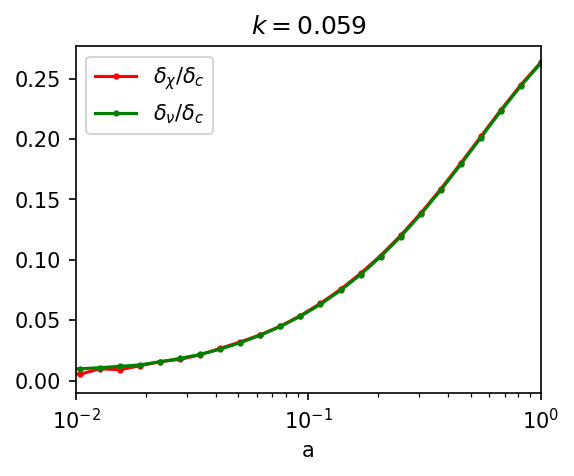

In [18]:
a_eval=np.logspace(-2.5,0,30)
chi_tk_z=[]
nu_tk_z=[]
for a in a_eval:
    chi_tk_z.append(chiCDM.get_transfer(z=1/a-1))
    nu_tk_z.append(nuCDM.get_transfer(z=1/a-1))
chi_tk_z=np.array(chi_tk_z)
nu_tk_z=np.array(nu_tk_z)


print(chi_tk_z[1].keys())
kidx=40
kEval=chi_tk_z[1]['k (h/Mpc)'][kidx]
print('Evaluating at k={:.6f}'.format(kEval))# print(tk['d_chi'].shape)

d_chi_z=-np.array([d['d_chi'][kidx] for d in chi_tk_z])
d_cdm_z=-np.array([d['d_cdm'][kidx] for d in chi_tk_z])
d_nu_z=-np.array([d['d_ncdm[0]'][kidx] for d in nu_tk_z])

chi_ratio=d_chi_z/d_cdm_z
nu_ratio=d_nu_z/d_cdm_z

plt.figure(figsize=(4,3), dpi=150)

plt.plot(a_eval,chi_ratio,'r-o',label=r'$\delta_\chi / \delta_c$', markersize=2.)
plt.plot(a_eval,nu_ratio,'g-o',label=r'$\delta_\nu / \delta_c$', markersize=2.)
plt.legend(loc='best')
plt.title(r'$k='+'{:.3f}'.format(kEval)+r'$')
plt.xlim([1.e-2,1])
plt.xscale('log')
plt.xlabel('a')
plt.show()

In [4]:
Ocb=0.27
aBOSS=1/(1+0.5)
from scipy.special import hyp2f1
Dz = aBOSS * hyp2f1(1./3, 1., 11./6, (Ocb - 1.) / Ocb * aBOSS**3)
D0 = hyp2f1(1./3, 1., 11./6, (Ocb - 1.) / Ocb)
dhyp = hyp2f1(4./3, 2., 17./6, (Ocb - 1.) / Ocb * aBOSS**3)
print(1. + (6./11) * aBOSS**4 / (Dz/D0) * (Ocb - 1.) / Ocb * dhyp)
print(0.78*2/3)

0.7899186471978995
0.52
